## Original Embedding

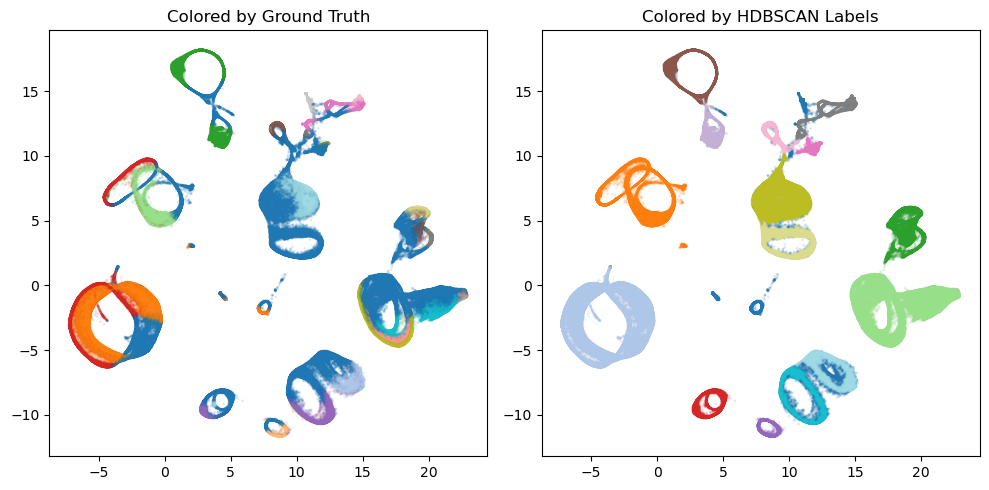

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


f = np.load("files/LLB16_folds_JointRun_fold2.npz")

embedding = f["embedding_outputs"]
neural_states = f["predictions"]
ground_truth = f["ground_truth_labels"]
hdbscan_labels = f["hdbscan_labels"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sc0 = axes[0].scatter(embedding[:, 0], embedding[:, 1], c=ground_truth, cmap="tab20", alpha=0.1, s=1)
axes[0].set_title("Colored by Ground Truth")

sc1 = axes[1].scatter(embedding[:, 0], embedding[:, 1], c=hdbscan_labels, cmap="tab20", alpha=0.1, s=1)
axes[1].set_title("Colored by HDBSCAN Labels")

plt.tight_layout()
plt.show()


# cluster the first 100k points with correlation distance
import umap
import numpy as np
import matplotlib.pyplot as plt

# ── load ----------------------------------------------------------------------
# cluster the first 100k points with correlation distance

x = umap.UMAP(
    n_neighbors=30,
    min_dist=0,
    metric="correlation",
    low_memory=True
).fit_transform(embedding[:100_000])

plt.scatter(x[:, 0], x[:, 1], c=ground_truth[:100_000], cmap="tab20", s=1, alpha=0.08)
plt.show()



## Balanced By Ground Truth Labels Weird Eucledian Distance Collapse To Point Wise

[164785  16443  11896   1718  40492   3618   8974  14969  21089   7543
  18945   7180   4516  12844   1525   2215   2696   2024   1859   4437
   2137   1815    804   1442    988   5161   5731   8248   4436  20405
    283]


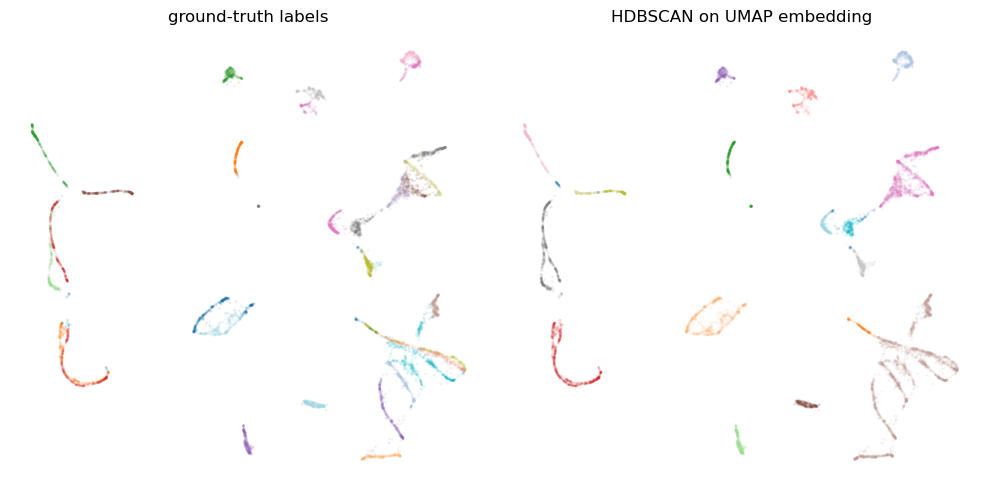

In [33]:
import numpy as np
import umap
import matplotlib.pyplot as plt

# ── load ----------------------------------------------------------------------
f              = np.load("files/LLB16_folds_JointRun_fold2.npz")
X              = f["predictions"]          # (N, D)
y_true         = f["ground_truth_labels"]
hdb_labels     = f["hdbscan_labels"]       # from your first pass

# ── build a BALANCED core set, one quota per GROUND TRUTH label -------------------
unique_labels, cnts = np.unique(y_true, return_counts=True)

print(cnts)

quota          = cnts.min()                # rarest ground truth label size
rng            = np.random.default_rng(42)

core_idx = np.hstack([
    rng.choice(np.where(y_true == c)[0], size=quota, replace=False)
    for c in unique_labels
])

# (optional) randomize order inside the core set
perm           = rng.permutation(len(core_idx))
core_idx       = core_idx[perm]

# ── slice *everything* with the same indices ----------------------------------
X_core         = X[core_idx]
y_core         = y_true[core_idx]
hdb_core       = hdb_labels[core_idx]

# ── keep only the first 100 000 if desired -------------------------------------
X_core   = X_core[:100_000]
y_core   = y_core[:100_000]
hdb_core = hdb_core[:100_000]

# ── fit UMAP on the balanced core ---------------------------------------------
x = umap.UMAP(
        n_neighbors=200,
        min_dist=0.1,
        metric="correlation"
    ).fit_transform(X_core)

# ── apply HDBSCAN to the new embedding ----------------------------------------
import hdbscan
hdbscan_new = hdbscan.HDBSCAN(min_cluster_size=50)
hdb_labels_new = hdbscan_new.fit_predict(x)

# ── viz -----------------------------------------------------------------------
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].scatter(x[:, 0], x[:, 1], c=y_core,  cmap="tab20", s=1, alpha=0.08)
ax[0].set_title("ground-truth labels")
ax[0].axis("off")

ax[1].scatter(x[:, 0], x[:, 1], c=hdb_labels_new, cmap="tab20", s=1, alpha=0.08)
ax[1].set_title("HDBSCAN on UMAP embedding")
ax[1].axis("off")

plt.tight_layout()
plt.show()


## Balance By HDBSCAN Labels

[76669 39643 23713 64041 12863  6678 10540 18271  5720  5340 10717 43016
 26638 24134 22856]
(80100, 196)


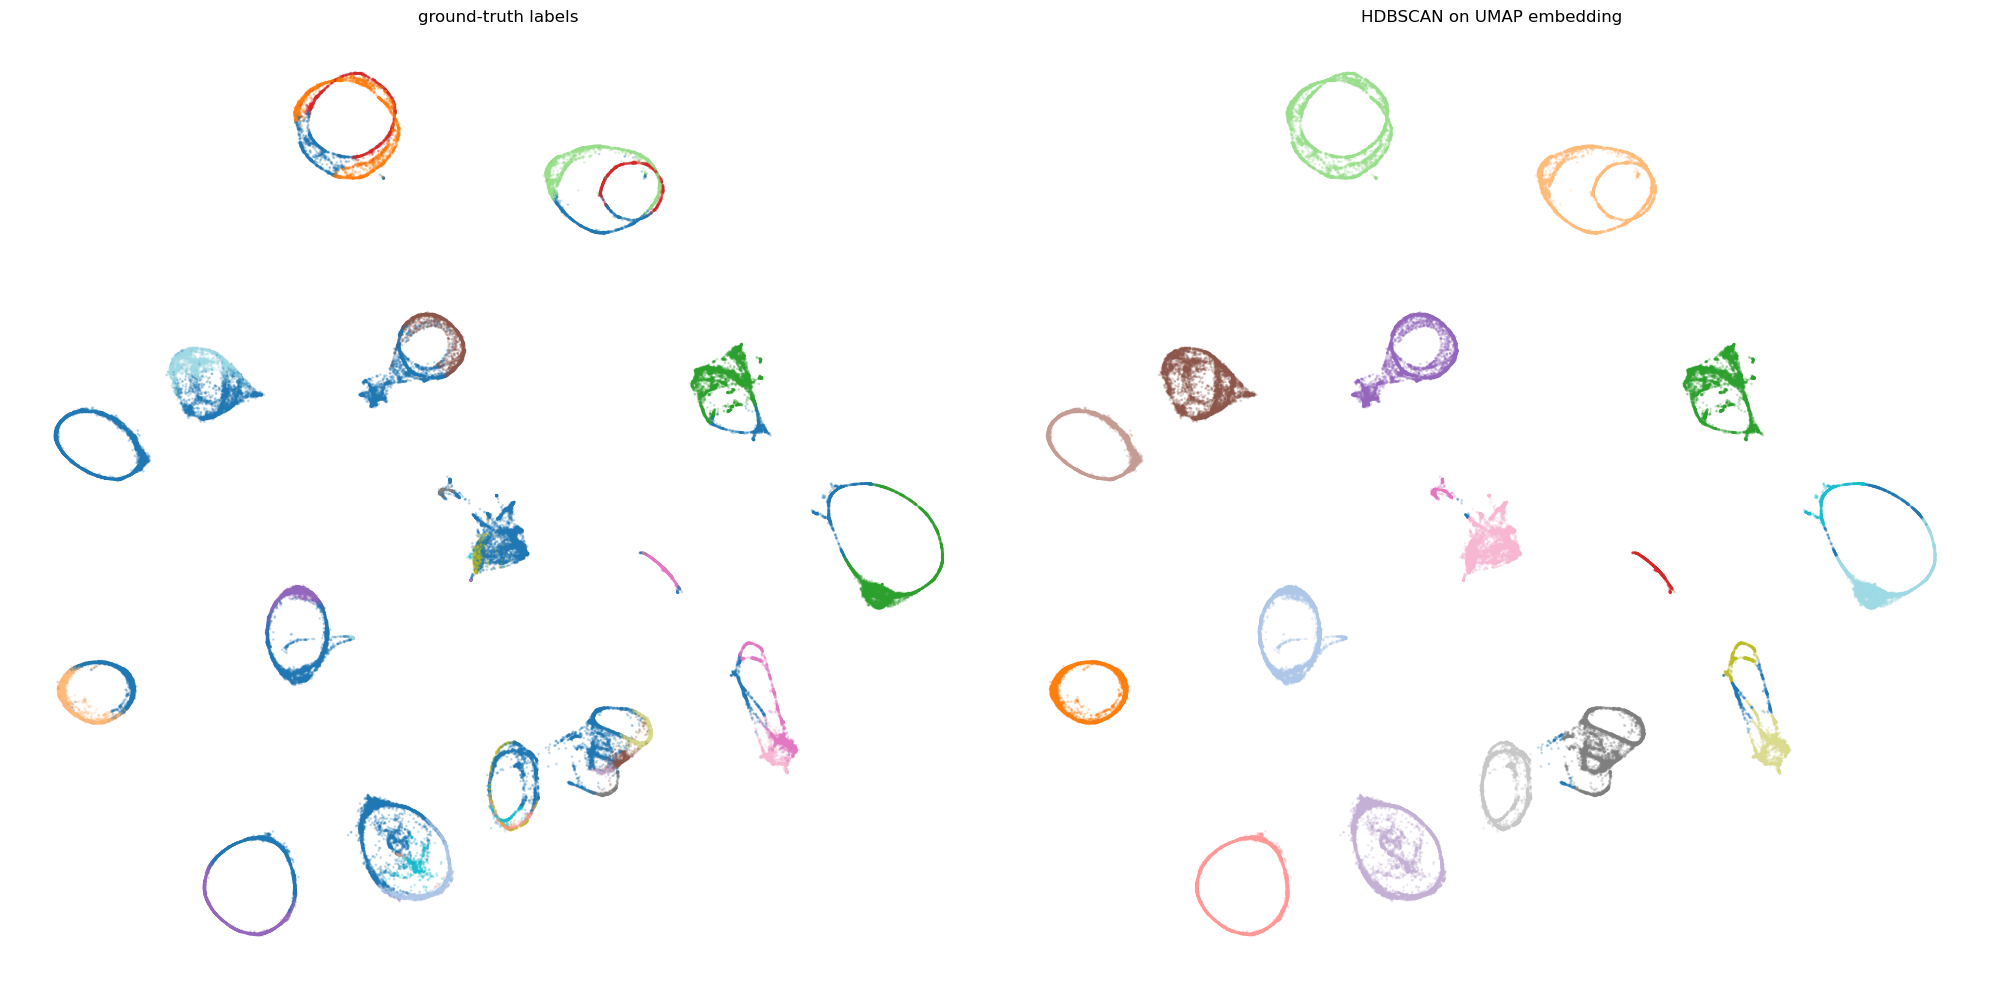

In [35]:
import numpy as np
import umap
import matplotlib.pyplot as plt

# ── load ----------------------------------------------------------------------
f              = np.load("files/LLB16_folds_JointRun_fold2.npz")
X              = f["predictions"]          # (N, D)
y_true         = f["ground_truth_labels"]
hdb_labels     = f["hdbscan_labels"]       # from your first pass

# ── build a BALANCED core set, one quota per HDBSCAN cluster -------------------
mask_clusters  = hdb_labels != -1
clusters, cnts = np.unique(hdb_labels[mask_clusters], return_counts=True)

print(cnts)

quota          = cnts.min()                # rarest cluster size
rng            = np.random.default_rng(42)

core_idx = np.hstack([
    rng.choice(np.where(hdb_labels == c)[0], size=quota, replace=False)
    for c in clusters
])

# (optional) randomize order inside the core set
perm           = rng.permutation(len(core_idx))
core_idx       = core_idx[perm]

# ── slice *everything* with the same indices ----------------------------------
X_core         = X[core_idx]
y_core         = y_true[core_idx]
hdb_core       = hdb_labels[core_idx]

# ── keep only the first 50 000 if desired -------------------------------------
X_core   = X_core[:100_000]
y_core   = y_core[:100_000]
hdb_core = hdb_core[:100_000]

print(X_core.shape)

# ── fit UMAP on the balanced core ---------------------------------------------
x = umap.UMAP(
        n_neighbors=30,
        min_dist=0,
        metric="canberra",
        low_memory=True
    ).fit_transform(X_core)

# ── apply HDBSCAN to the new embedding ----------------------------------------
import hdbscan
hdbscan_new = hdbscan.HDBSCAN(min_cluster_size=500)
hdb_labels_new = hdbscan_new.fit_predict(x)

# ── viz -----------------------------------------------------------------------
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].scatter(x[:, 0], x[:, 1], c=y_core,  cmap="tab20", s=1, alpha=0.2)
ax[0].set_title("ground-truth labels")
ax[0].axis("off")

ax[1].scatter(x[:, 0], x[:, 1], c=hdb_labels_new, cmap="tab20", s=1, alpha=0.2)
ax[1].set_title("HDBSCAN on UMAP embedding")
ax[1].axis("off")

plt.tight_layout()
plt.show()


## Viz Densities 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import mode
import imageio

def voxel_density_from_2d(x, labels, bins=(50,50), max_height=None):
    H, xedges, yedges = np.histogram2d(x[:,0], x[:,1], bins=bins)
    ix = np.digitize(x[:,0], xedges) - 1
    iy = np.digitize(x[:,1], yedges) - 1
    ix = np.clip(ix, 0, bins[0]-1)
    iy = np.clip(iy, 0, bins[1]-1)

    # Vectorized mode computation
    flat_bin = ix * bins[1] + iy
    mode_label = np.full(bins, -1, dtype=int)
    for b in np.unique(flat_bin):
        mask = flat_bin == b
        i, j = divmod(b, bins[1])
        mode_label[i, j] = mode(labels[mask], keepdims=False).mode

    max_h = int(H.max()) if max_height is None else int(max_height)
    voxels = np.zeros((bins[0], bins[1], max_h), dtype=bool)
    for i in range(bins[0]):
        for j in range(bins[1]):
            h = min(int(H[i,j]), max_h)
            if h>0:
                voxels[i,j, :h] = True
    return voxels, mode_label

def save_voxel_density_gif(x, labels, bins=(50,50), max_height=None, title="", gif_path="spin.gif", n_frames=36):
    voxels, mode_label = voxel_density_from_2d(x, labels, bins, max_height)
    cmap = plt.cm.get_cmap("tab20", np.max(labels)+1)
    facecolors = np.zeros(voxels.shape + (4,))
    nx, ny, nz = voxels.shape
    for i in range(nx):
        for j in range(ny):
            lbl = mode_label[i,j]
            if lbl<0: continue
            col = cmap(lbl)
            h = voxels[i,j,:].sum()
            facecolors[i,j, :h] = col

    images = []
    for angle in np.linspace(0, 360, n_frames, endpoint=False):
        fig = plt.figure(figsize=(8,6))
        ax = fig.add_subplot(111, projection='3d')
        ax.voxels(voxels, facecolors=facecolors, edgecolor=None)
        ax.set_title(title)
        ax.set_xlabel("UMAP 1")
        ax.set_ylabel("UMAP 2")
        ax.set_zlabel("point density")
        ax.view_init(elev=30, azim=angle)
        plt.tight_layout()
        # Save to buffer
        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        images.append(image)
        plt.close(fig)
    imageio.mimsave(gif_path, images, duration=0.08)

# usage:
# assumes x.shape == (N,2)
save_voxel_density_gif(x, y_core,
                       bins=(40,40),
                       title="voxel density (ground truth)",
                       gif_path="voxel_density_ground_truth.gif",
                       n_frames=36)

/tmp/ipykernel_854650/1617297537.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab20", np.max(labels)+1)
/tmp/ipykernel_854650/1617297537.py:58: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')


KeyboardInterrupt: 

# random 50 k + inverse-frequency sample_weight

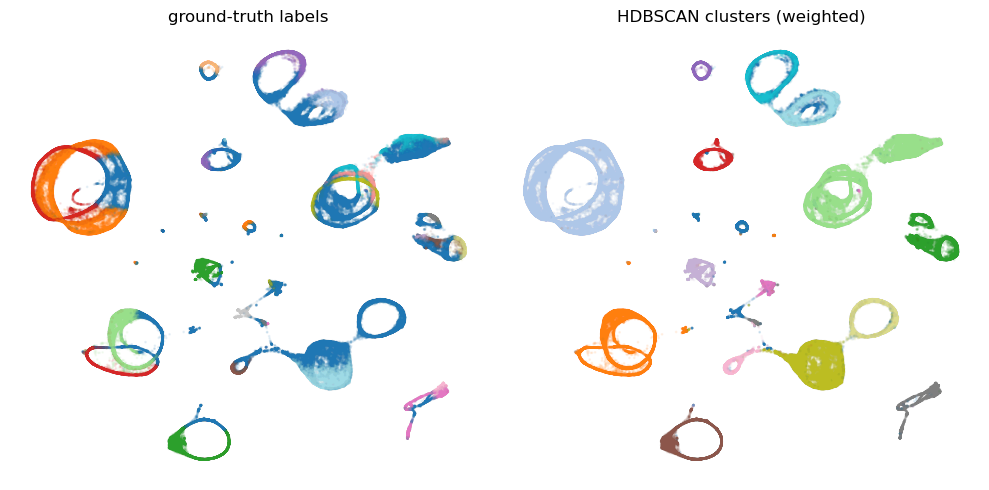

In [37]:
import numpy as np
import umap
import matplotlib.pyplot as plt

# ── load ───────────────────────────────────────────────────────────────────────
f          = np.load("files/LLB16_folds_JointRun_fold2.npz")
X          = f["predictions"]
y_true     = f["ground_truth_labels"]
hdb_labels = f["hdbscan_labels"]

rng        = np.random.default_rng(42)

# ── draw a random 50 k subset ─────────────────────────────────────────────────
idx        = rng.choice(len(X), size=300_000, replace=False)
X_sub      = X[idx]
y_sub      = y_true[idx]
hdb_sub    = hdb_labels[idx]

# ── inverse-frequency weights *per HDBSCAN cluster* ───────────────────────────
shift_full = hdb_labels + 1          # map −1→0 so bincount works
freq_full  = np.bincount(shift_full) # global cluster frequencies

shift_sub  = hdb_sub + 1
weights    = 1.0 / freq_full[shift_sub]
weights   /= weights.mean()          # normalise around 1

# optional: down-weight noise points (cluster −1)
# weights[shift_sub == 0] *= 0.1

# ── UMAP ──────────────────────────────────────────────────────────────────────
u = umap.UMAP(
        n_neighbors=30,
        min_dist=0,
        metric="canberra",
        low_memory=True
    )
x = u.fit_transform(X_sub, sample_weight=weights)

# ── viz ───────────────────────────────────────────────────────────────────────
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].scatter(x[:, 0], x[:, 1], c=y_sub,  cmap="tab20", s=1, alpha=0.08)
ax[0].set_title("ground-truth labels")
ax[0].axis("off")

ax[1].scatter(x[:, 0], x[:, 1], c=hdb_sub, cmap="tab20", s=1, alpha=0.08)
ax[1].set_title("HDBSCAN clusters (weighted)")
ax[1].axis("off")

plt.tight_layout()
plt.show()

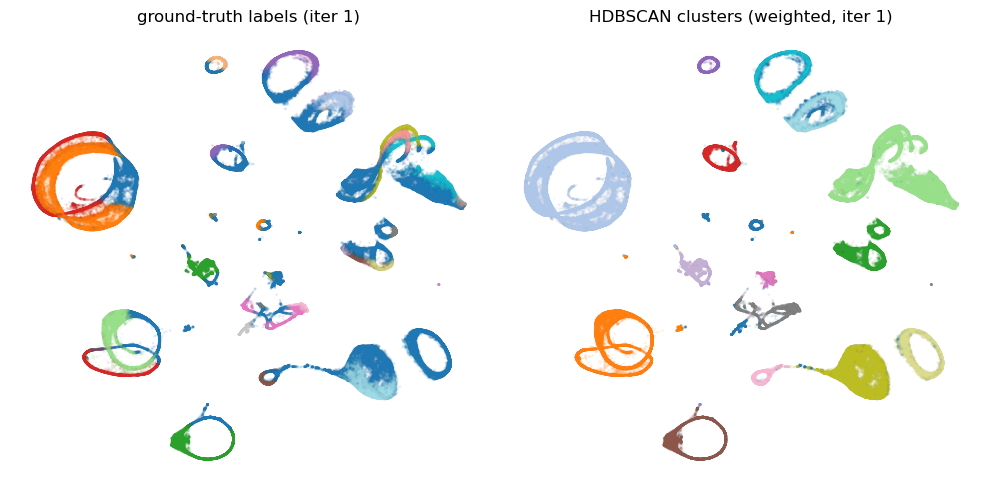

In [ ]:
import numpy as np
import umap
import matplotlib.pyplot as plt

# ── load ───────────────────────────────────────────────────────────────────────
f          = np.load("files/LLB16_folds_JointRun_fold2.npz")
X          = f["predictions"]
y_true     = f["ground_truth_labels"]
hdb_labels = f["hdbscan_labels"]

rng        = np.random.default_rng(42)

# ── draw a random 300 k subset ────────────────────────────────────────────────
idx        = rng.choice(len(X), size=300_000, replace=False)
X_sub      = X[idx]
y_sub      = y_true[idx]
hdb_sub    = hdb_labels[idx]

# For iterative relabeling
hdb_iter = hdb_sub.copy()

for i in range(5):
    # ── inverse-frequency weights *per HDBSCAN cluster* ───────────────────────
    shift_full = hdb_iter + 1          # map −1→0 so bincount works
    freq_full  = np.bincount(shift_full) # global cluster frequencies

    shift_sub  = hdb_iter + 1
    weights    = 1.0 / freq_full[shift_sub]
    weights   /= weights.mean()          # normalise around 1

    # optional: down-weight noise points (cluster −1)
    # weights[shift_sub == 0] *= 0.1

    # ── UMAP ──────────────────────────────────────────────────────────────────
    u = umap.UMAP(
            n_neighbors=30,
            min_dist=0,
            metric="canberra",
            low_memory=True
        )
    x = u.fit_transform(X_sub, sample_weight=weights)

    # ── viz ───────────────────────────────────────────────────────────────────
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    ax[0].scatter(x[:, 0], x[:, 1], c=y_sub,  cmap="tab20", s=1, alpha=0.08)
    ax[0].set_title(f"ground-truth labels (iter {i+1})")
    ax[0].axis("off")

    ax[1].scatter(x[:, 0], x[:, 1], c=hdb_iter, cmap="tab20", s=1, alpha=0.08)
    ax[1].set_title(f"HDBSCAN clusters (weighted, iter {i+1})")
    ax[1].axis("off")

    plt.tight_layout()
    plt.show()

    # For next iteration, relabel using HDBSCAN on the same X_sub
    import hdbscan
    clusterer = hdbscan.HDBSCAN(min_cluster_size=30)
    hdb_iter = clusterer.fit_predict(X_sub)

## oversample to a perfectly balanced 50 k

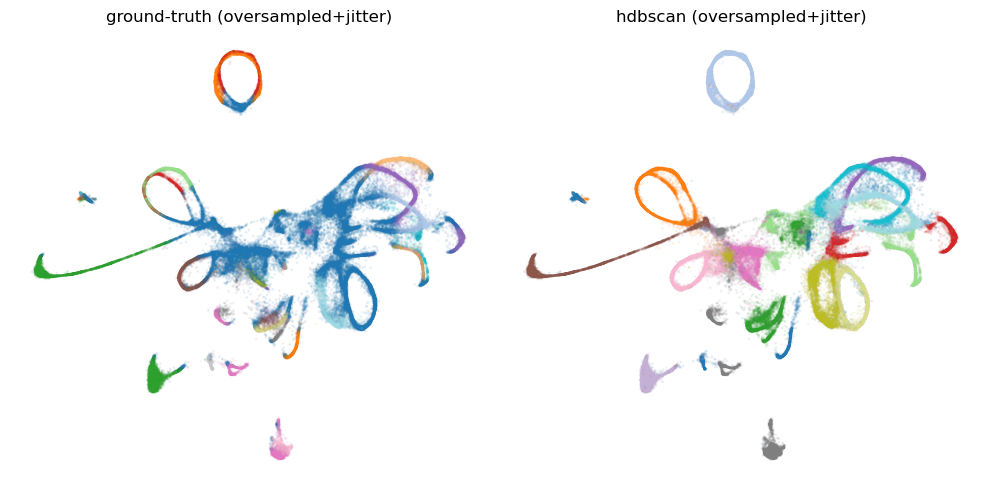

In [18]:
import numpy as np, umap, matplotlib.pyplot as plt
from math import ceil

# ── load ───────────────────────────────────────────────────────────────────────
f          = np.load("files/LLB16_folds_JointRun_fold2.npz")
X          = f["predictions"]
y_true     = f["ground_truth_labels"]
hdb_labels = f["hdbscan_labels"]

rng        = np.random.default_rng(42)

# ── oversample every HDB cluster to equal quota ───────────────────────────────
labels     = np.unique(hdb_labels)
n_classes  = len(labels)
per_class  = ceil(100_000 / n_classes)        # target rows per cluster

sel_X, sel_y, sel_hdb = [], [], []

for lbl in labels:
    pool = np.where(hdb_labels == lbl)[0]
    picks = rng.choice(pool, size=per_class, replace=len(pool) < per_class)

    # grab the originals
    sel_X.append(X[picks])
    sel_y.append(y_true[picks])
    sel_hdb.append(np.full(per_class, lbl))

# concat and trim back to 50 k
X_bal   = np.vstack(sel_X)[:100_000]
y_bal   = np.hstack(sel_y)[:100_000]
hdb_bal = np.hstack(sel_hdb)[:100_000]

# ── micro-jitter duplicates so they’re not exact copies ───────────────────────
eps     = 1e-1 * X.std(axis=0)               # per-dim scale
X_bal   = X_bal + rng.normal(0, eps, size=X_bal.shape)

# ── UMAP ──────────────────────────────────────────────────────────────────────
u       = umap.UMAP(
            n_neighbors=30,
            min_dist=0.1,
            metric="correlation",
            low_memory=True
        )
x       = u.fit_transform(X_bal)

# ── viz ───────────────────────────────────────────────────────────────────────
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].scatter(x[:,0], x[:,1], c=y_bal,  cmap="tab20", s=1, alpha=0.08)
ax[0].set_title("ground-truth (oversampled+jitter)")
ax[0].axis("off")

ax[1].scatter(x[:,0], x[:,1], c=hdb_bal, cmap="tab20", s=1, alpha=0.08)
ax[1].set_title("hdbscan (oversampled+jitter)")
ax[1].axis("off")

plt.tight_layout(); plt.show()

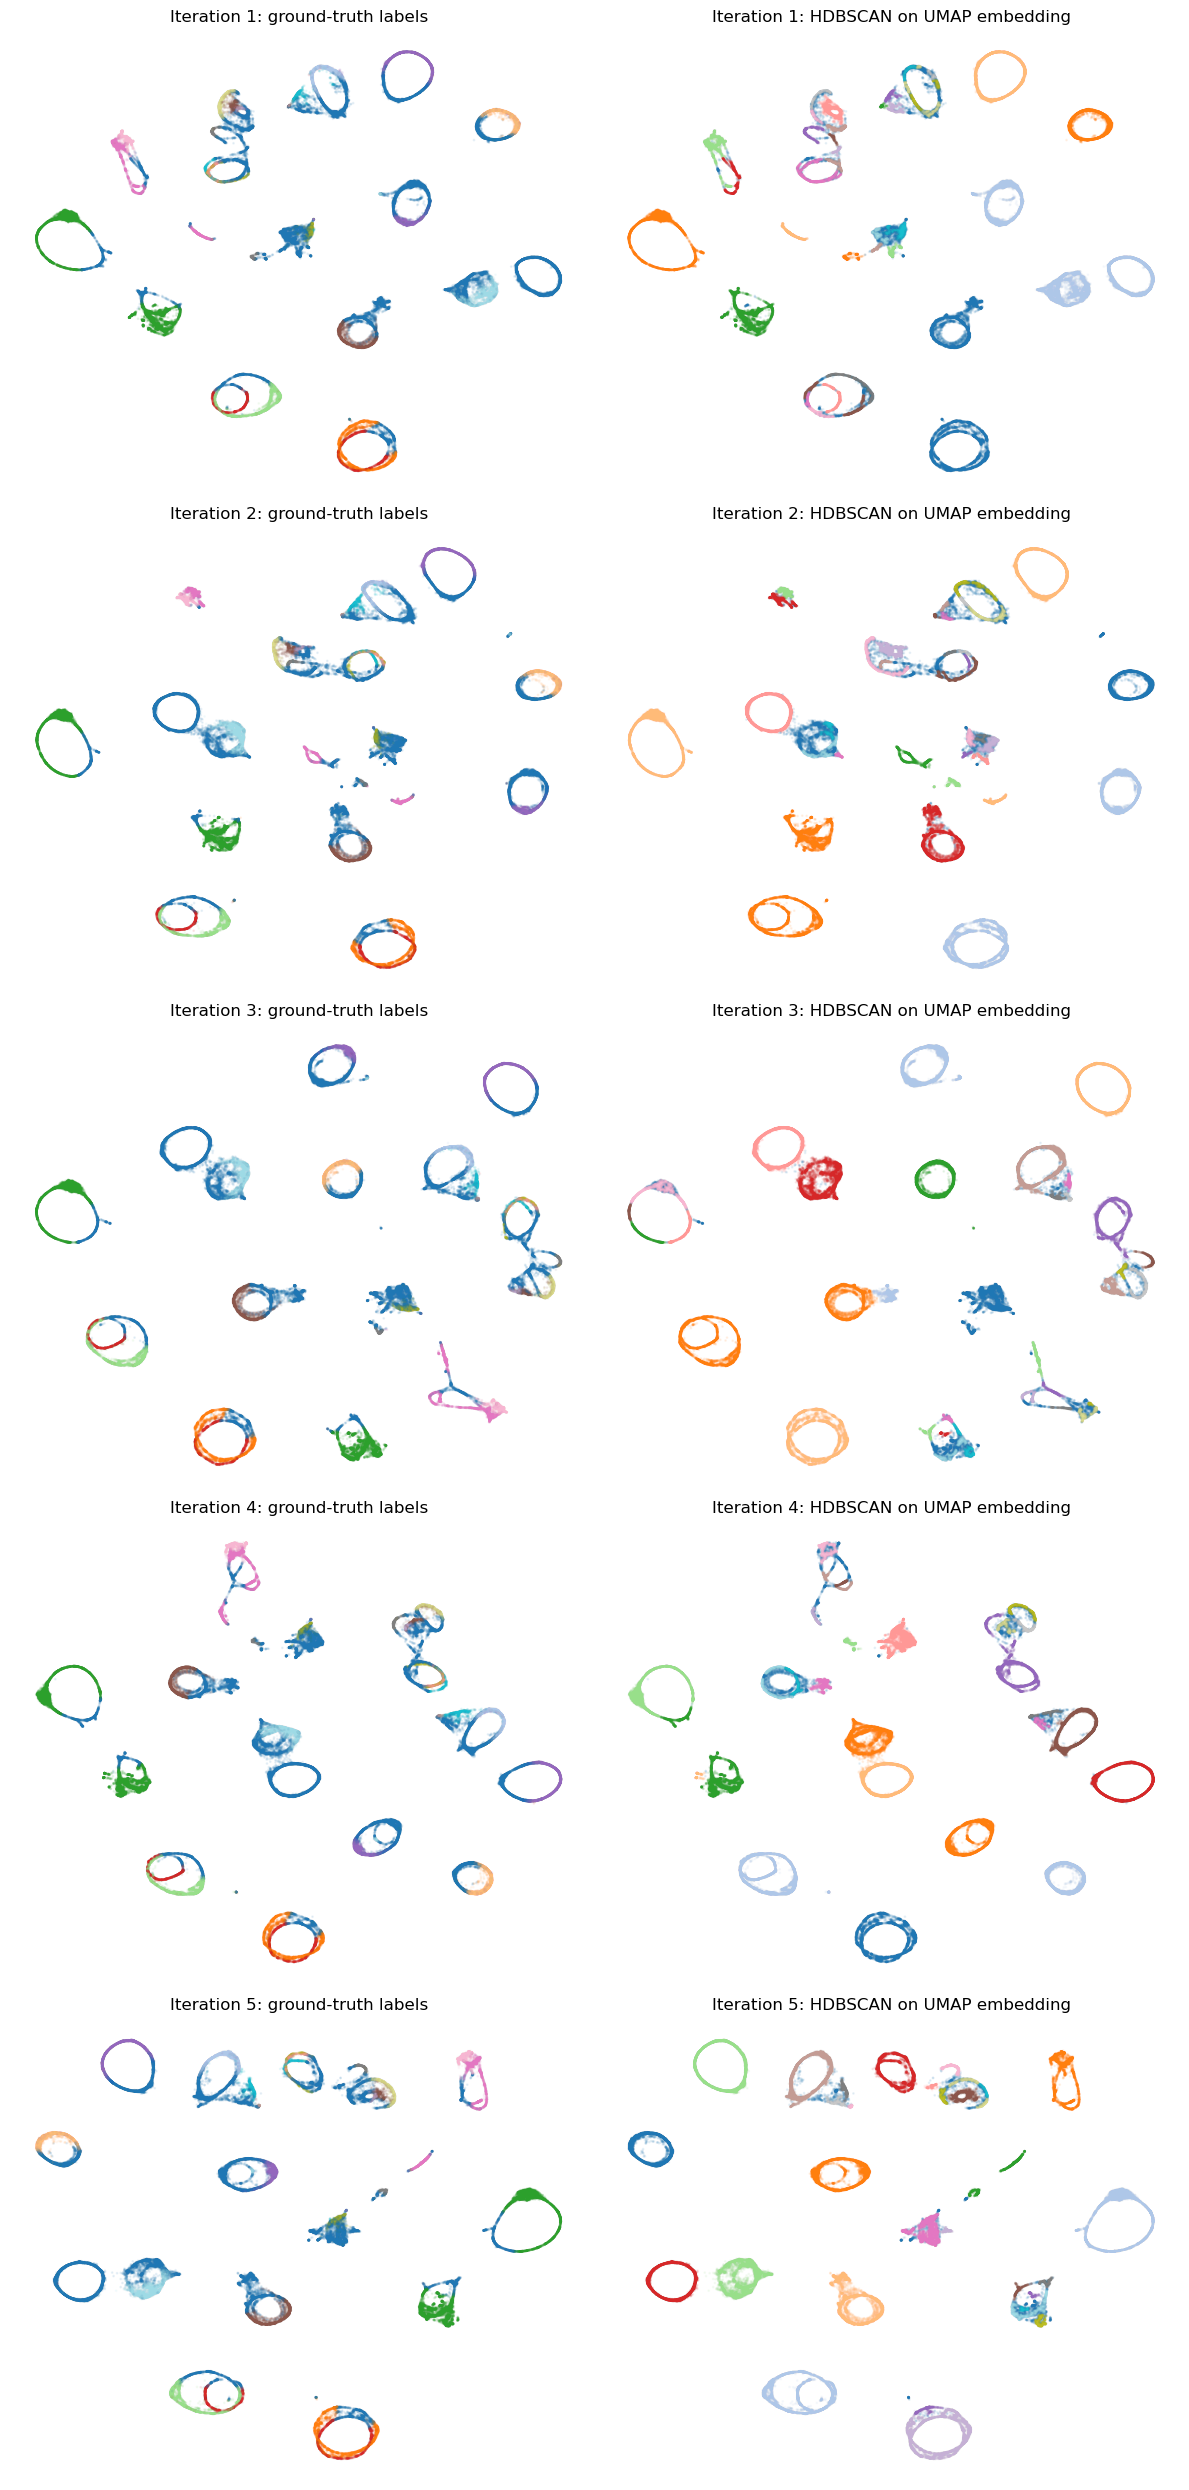

In [6]:
import numpy as np
import umap
import matplotlib.pyplot as plt
import hdbscan

# ── load ----------------------------------------------------------------------
f              = np.load("files/LLB16_folds_JointRun_fold2.npz")
X              = f["predictions"]          # (N, D)
y_true         = f["ground_truth_labels"]
hdb_labels     = f["hdbscan_labels"]       # from your first pass

umap_results = []
y_cores = []
hdb_labels_news = []

for i in range(5):
    # ── build a BALANCED core set, one quota per HDBSCAN cluster -------------------
    mask_clusters  = hdb_labels != -1
    clusters, cnts = np.unique(hdb_labels[mask_clusters], return_counts=True)

    quota          = cnts.min()                # rarest cluster size
    rng            = np.random.default_rng(42 + i)  # different seed each iteration

    core_idx = np.hstack([
        rng.choice(np.where(hdb_labels == c)[0], size=quota, replace=False)
        for c in clusters
    ])

    # (optional) randomize order inside the core set
    perm           = rng.permutation(len(core_idx))
    core_idx       = core_idx[perm]

    # ── slice *everything* with the same indices ----------------------------------
    X_core         = X[core_idx]
    y_core         = y_true[core_idx]
    hdb_core       = hdb_labels[core_idx]

    # ── keep only the first 30 000 if desired -------------------------------------
    X_core   = X_core[:100_000]
    y_core   = y_core[:100_000]
    hdb_core = hdb_core[:100_000]

    # ── fit UMAP on the balanced core ---------------------------------------------
    x = umap.UMAP(
            n_neighbors=30,
            min_dist=0,
            metric="canberra",
            low_memory=True
        ).fit_transform(X_core)
    # ── apply HDBSCAN to the new embedding ----------------------------------------
    hdbscan_new = hdbscan.HDBSCAN(min_cluster_size=200, min_samples=10)
    hdb_labels_new = hdbscan_new.fit_predict(x)

    umap_results.append(x)
    y_cores.append(y_core)
    hdb_labels_news.append(hdb_labels_new)

# ── viz: plot all 5 UMAPs -----------------------------------------------------
fig, axes = plt.subplots(5, 2, figsize=(12, 25))

for i in range(5):
    axes[i, 0].scatter(umap_results[i][:, 0], umap_results[i][:, 1], c=y_cores[i], cmap="tab20", s=1, alpha=0.08)
    axes[i, 0].set_title(f"Iteration {i+1}: ground-truth labels")
    axes[i, 0].axis("off")

    axes[i, 1].scatter(umap_results[i][:, 0], umap_results[i][:, 1], c=hdb_labels_news[i], cmap="tab20", s=1, alpha=0.08)
    axes[i, 1].set_title(f"Iteration {i+1}: HDBSCAN on UMAP embedding")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()
